# Data Science - Laboratorio 3
## Modelos Long-Short Term Memory (LSTM)
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -

### Librerias

In [1]:
# Manejo de archivos
import os 

# Manipulación de datos
import pandas as pd
import numpy as np
import random
from datetime import datetime

# Visualización
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Estadística y series temporales ARIMA
import statsmodels.tsa as tsa
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

# Métricas
from sklearn.metrics import mean_squared_error, accuracy_score

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Scikit-learn
from sklearn.preprocessing import StandardScaler

# advertencias
import warnings
warnings.filterwarnings('ignore')

### Carga de Datasets

In [2]:
# Ruta de la carpeta con los archivos
folder_path = 'data'

# Obtener los nombres de los archivos
file_names = [file for file in os.listdir(folder_path) if file.endswith('.csv') and not file.startswith('~')]

# Diccionario para almacenar los dataframes
data_frames = {}

# Iterar sobre los nombres de los archivos
for file in file_names:
    # Construir la ruta del archivo
    file_path = os.path.join(folder_path, file)
    file_name = file.split('.')[0]
    
    # Leer el archivo csv y almacenarlo en un dataframe
    df = pd.read_csv(file_path, sep=';', encoding='utf-8')
    
    # Guardar el dataframe en el diccionario con el nombre del archivo como clave
    data_frames[file_name] = df

# Mostrar los nombres de los archivos
print(f"Se cargaron un total de {len(data_frames)} archivos\n")
print('Archivos cargados:')
for key in data_frames.keys():
    print(f"\t- {key}")

Se cargaron un total de 3 archivos

Archivos cargados:
	- consumos_combustibles
	- importaciones_combustibles
	- precios_combustibles


In [3]:
# cargar cada dataset como su propio dataframe
consumos = data_frames['consumos_combustibles']
importaciones = data_frames['importaciones_combustibles']
precios = data_frames['precios_combustibles']

## Preprocesamiento

### Seleccion de Variables

Solo se tomarán en cuenta los datos de importación, consumo y precios de los siguientes tipos de combustibles:
- `Gasolina Súper`
- `Gasolina Regular`
- `Diesel` -> combinacion de Diesel alto azufre y bajo azufre
- `Gas Propano`

In [4]:
# Seleccionar las columnas de interés para consumos e importaciones
cols = ['Fecha','Gasolina regular', 'Gasolina superior', 'Diesel alto azufre', 'Diesel bajo azufre', 'Gas licuado de petróleo']

# Filtrar columnas en 'consumo_combustibles'
consumos = consumos[cols].copy()

# Filtrar columnas en 'importacion_combustibles'
importaciones = importaciones[cols].copy()

# Filtrar columnas en 'precios_combustibles'
precios_cols = ['FECHA','Superior GTQ/GALON', 'Regular GTQ/GALON', 'Diesel GTQ/GALON', 'Glp Cilindro 25Lbs GTQ/LB']
precios = precios[precios_cols].copy()

### Verificacion y manejo de Nulos

En el laboratorio anterior se encontro que Ceras y tipo cambio eran las variables con nulos. Dado que ahora se seleccionaron las variables de interes antes, es probable que ya no existan nulos.

In [5]:
# Comprobar si hay valores nulos
print("Valores nulos en el dataset de consumo de combustibles:", consumos.isnull().sum().sum())
print("Valores nulos en el dataset de importación de combustibles:", importaciones.isnull().sum().sum())
print("Valores nulos en el dataset de precios de combustibles:", precios.isnull().sum().sum())

Valores nulos en el dataset de consumo de combustibles: 0
Valores nulos en el dataset de importación de combustibles: 0
Valores nulos en el dataset de precios de combustibles: 0


### Manejo de Fechas

Anterormente se encontro que los 3 datasets contienen una unica variable culitativa la cual es `Fecha`. Esta se encuentra como string por lo que se debe de transformar a datetime

In [6]:
# Diccionario de meses en español a inglés
month_mapping = {
    'ene': 'Jan',
    'feb': 'Feb',
    'mar': 'Mar',
    'abr': 'Apr',
    'may': 'May',
    'jun': 'Jun',
    'jul': 'Jul',
    'ago': 'Aug',
    'sep': 'Sep',
    'oct': 'Oct',
    'nov': 'Nov',
    'dic': 'Dec'
}

# Función para reemplazar los nombres de los meses
def replace_months(date_str):
    for esp, eng in month_mapping.items():
        date_str = date_str.replace(esp, eng)
    return date_str

# Por fines practicos, se renombra la columna  'FECHA' a 'Fecha' en el dataset de precios de combustibles
precios.rename(columns={'FECHA': 'Fecha'}, inplace=True)

# Aplicar la función a las columnas de fecha de los dataframes
consumos['Fecha'] = consumos['Fecha'].apply(replace_months)
importaciones['Fecha'] = importaciones['Fecha'].apply(replace_months)
precios['Fecha'] = precios['Fecha'].apply(replace_months)

# Convertir las columnas de fecha a datetime
consumos['Fecha'] = pd.to_datetime(consumos['Fecha'], format='%b/%Y')
importaciones['Fecha'] = pd.to_datetime(importaciones['Fecha'], format='%b/%Y')
precios['Fecha'] = pd.to_datetime(precios['Fecha'], format='%d/%b/%Y')

# Establecer la columna 'Fecha' como índice en los tres dataframes
consumos.set_index('Fecha', inplace=True)
importaciones.set_index('Fecha', inplace=True)
precios.set_index('Fecha', inplace=True)

# Converir los indices a datetime
consumos.index = pd.to_datetime(consumos.index)
importaciones.index = pd.to_datetime(importaciones.index)
precios.index = pd.to_datetime(precios.index)

# Ordenar los índices
consumos.sort_index(inplace=True)
importaciones.sort_index(inplace=True)
precios.sort_index(inplace=True)

# Inferir la frecuencia de los índices
pd.infer_freq(consumos.index)
pd.infer_freq(importaciones.index)
pd.infer_freq(precios.index)


'D'

### Manejo de variables Diesel

Es necesario combinar ambas variables de diesel en una unica variable donde las fechas de antes del 2018 se tomaran para el diesel alto en azufre, posterior a 2018 se tomaran las de diesel alto en azufre.

In [7]:
def combine_diesel(df, high_sulfur_col, low_sulfur_col, combined_col):
    """
    Función que combina las columnas de Diesel de alto y bajo azufre en una sola columna.
    Toma los valores de Diesel de alto azufre hasta 2017 y los de Diesel de bajo azufre a partir de 2018.

    Args:
        df (pandas.DataFrame): El dataframe de entrada.
        high_sulfur_col (str): El nombre de la columna de Diesel de alto azufre.
        low_sulfur_col (str): El nombre de la columna de Diesel de bajo azufre.
        combined_col (str): El nombre de la nueva columna combinada.
    
    Returns:
        data (pandas.DataFrame): El dataframe de entrada con la nueva columna combinada.
    """
    # Crear una copia del dataframe
    data = df.copy()

    # Crear una nueva columna con los valores de Diesel de alto azufre
    data.loc[data.index < '2018-01-01', combined_col] = data[high_sulfur_col]
    data.loc[data.index >= '2018-01-01', combined_col] = data[low_sulfur_col]

    # Eliminar las columnas originales
    data.drop(columns=[high_sulfur_col, low_sulfur_col], inplace=True)

    return data

In [8]:
# Combina las columnas de Diesel de alto y bajo azufre en una sola columna
consumos = combine_diesel(consumos, 'Diesel alto azufre', 'Diesel bajo azufre', 'Diesel')
importaciones = combine_diesel(importaciones, 'Diesel alto azufre', 'Diesel bajo azufre', 'Diesel')

### Renombrar Variables

Por fines practicos se renombraran las variables

In [9]:
precios.rename(columns={
    'Superior GTQ/GALON': 'Gasolina Superior',
    'Regular GTQ/GALON': 'Gasolina Regular',
    'Diesel GTQ/GALON': 'Diesel',
    'Glp Cilindro 25Lbs GTQ/LB': 'Gas Propano'
}, inplace=True)

# Renombrar columnas en 'consumo_combustibles'
consumos.rename(columns={
    'Gasolina regular': 'Gasolina Regular',
    'Gasolina superior': 'Gasolina Superior',
    'Gas licuado de petróleo': 'Gas Propano'
}, inplace=True)

# Renombrar columnas en 'importacion_combustibles'
importaciones.rename(columns={
    'Gasolina regular': 'Gasolina Regular',
    'Gasolina superior': 'Gasolina Superior',
    'Gas licuado de petróleo': 'Gas Propano'
}, inplace=True)

## Modelos LSTM

### Configuracion de PyTorch con CUDA

In [10]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Multi-GPU.
    print("Using CUDA")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using CUDA


### Transformación de Series

Como se encontro anteriormente las series de tiempo tienen una tendencia al alza y tienen patrones periodicos por lo tanto se necesita transformar la data para eliminar esta tendencia y tener series de tiempo estacionarias.

In [11]:
consumos_log = np.log(consumos)
consumos_diff = consumos_log.diff().dropna()

### Division de datos

In [12]:
test_size = 36
data = consumos_diff['Gasolina Regular'].values.astype(float)
train_data = data[:-test_size]
test_data = data[-test_size:]

### Normalización de Series

In [13]:
scaler = StandardScaler()
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

### Tensores

In [14]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [15]:
train_window = 12

In [16]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [17]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

### Arquitectura LSTM

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [19]:
def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for seq, _ in test_loader:
            seq = seq.unsqueeze(-1)  # Add feature dimension
            pred = model(seq)
            predictions.append(pred.squeeze().numpy())
    return np.concatenate(predictions)


In [20]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


### Entrenamiento

In [21]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00138944
epoch:  26 loss: 0.00276129
epoch:  51 loss: 0.00119639
epoch:  76 loss: 0.00012471
epoch: 101 loss: 0.00356712
epoch: 126 loss: 0.00372865
epoch: 149 loss: 0.0091887815


### Predicciones

In [22]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.7087271213531494, 0.8651362657546997, 1.2593110799789429, 0.16730020940303802, 0.22682733833789825, -0.4589235186576843, 1.5608913898468018, -1.1659209728240967, -0.2904288172721863, 1.379123330116272, -1.1981450319290161, 0.2197936773300171]


In [23]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [24]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

# Assuming consumos_diff['Gasolina Regular'] is your series of interest
test_size = 36
data = consumos_diff['Gasolina Regular'].values.astype(float)
train_data = data[:-test_size]
test_data = data[-test_size:]

scaler = StandardScaler()
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.reshape(-1, 1))

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
train_window = 12

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

def predict(model, test_data, train_window):
    model.eval()
    predictions = []
    test_inputs = torch.FloatTensor(test_data[:train_window])
    with torch.no_grad():
        for i in range(len(test_data) - train_window):
            seq = test_inputs[-train_window:].view(-1)
            test_inputs = torch.cat((test_inputs, model(seq).view(1)))
            predictions.append(test_inputs[-1].item())
    return predictions

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 150
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

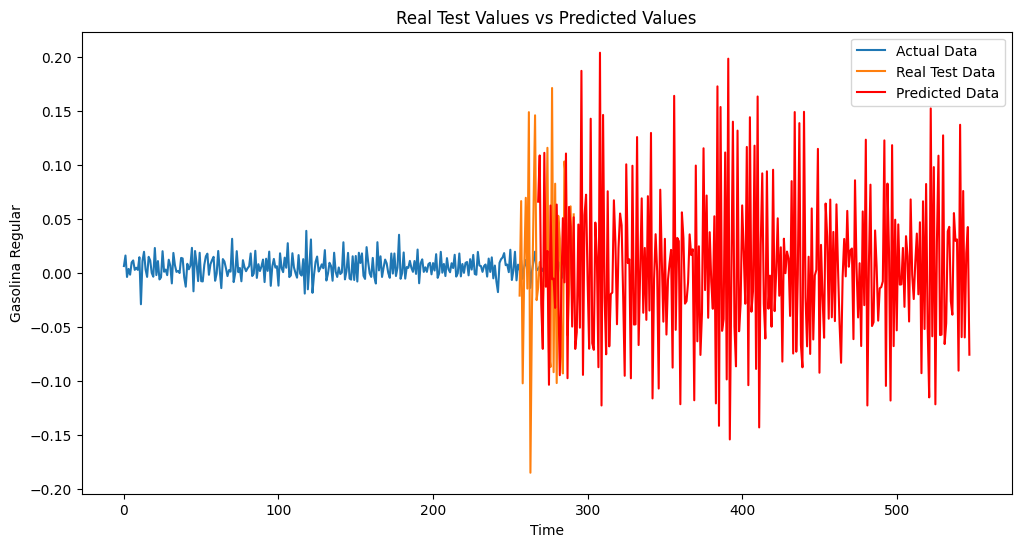

In [26]:
# Calcula predicciones
predicted_values = predict(model, train_data_normalized.tolist() + test_data_normalized.tolist(), train_window)

# Inversa de la transformación
predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
test_data_actual = scaler.inverse_transform(test_data_normalized.reshape(-1, 1))

# Ajusta el rango x para las predicciones
predicted_range = range(len(train_data) + train_window, len(train_data) + train_window + len(predicted_values))

# Plot resultados
plt.figure(figsize=(12,6))
plt.plot(range(len(data)), scaler.inverse_transform(data.reshape(-1, 1)), label='Actual Data')
plt.plot(range(len(train_data), len(data)), test_data_actual, label='Real Test Data')
plt.plot(predicted_range, predicted_values, label='Predicted Data', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Gasolina Regular')
plt.title('Real Test Values vs Predicted Values')
plt.show()